# Feature Engineering and Selection

In this notebook we'll first perform rudimentary feature engineering using the custom pipelines in `utils.pipelines` and subsequently perform feature selection based on linear correlation coefficients to mitigate multicollinearity.

## Feature Engineering

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, FeatureUnion

from utils.pipelines import *

data = pd.read_csv("../data/train.csv")
data_test = pd.read_csv("../data/test.csv")

We will first consider numerical and then categorical features. The features were chosen based on the insights from the exploratory data analysis. The feature imputation for missing values is performed in all individual feature extraction pipelines (based on the insights from the feature exploration notebook).

Potential Improvements / TODO:

- More ways to extract features from semi-continuous features
- More ways to extract features from multiclass categorical features

#### Continuous Numerical Features

In [2]:
all_features = []

# get continuous features log-scaled features
continuous_sel = ["LotArea", "1stFlrSF", "GrLivArea"]
all_features += continuous_sel

continuous_log_features = Pipeline([
    ("Selector", DataFrameSelector(continuous_sel)),
    ("LogTransform", LogTransformer()),
    ("MedianImputer", DataFrameImputer(strategy="median"))
])

# all continuous features benefit from the log scaling!

#### Semi-Continuous Numerical Features

In [3]:
# log scaled non-zero values + imputation with median
semicon_scaled_sel = ['LotFrontage', 'TotalBsmtSF', 'WoodDeckSF']
all_features += semicon_scaled_sel

semicon_log_features = Pipeline([
    ("Selector", DataFrameSelector(semicon_scaled_sel)),
    ("ZeroImputer", ZeroImputer()),
    ("SemiConLogFeatureTransform", SemiContinuousFeatureTransform(log_scale=True)),
])

# non scaled non-zero values + imputation with median
semicon_non_sel = ['BsmtFinSF1', 'GarageArea', "2ndFlrSF"]
all_features += semicon_non_sel

semicon_nonscaled_features = Pipeline([
    ("Selector", DataFrameSelector(semicon_non_sel)),
    ("ZeroImputer", ZeroImputer()),
    ("SemiConLogFeatureTransform", SemiContinuousFeatureTransform(log_scale=False)),
])

#### Discrete Numerical Features

In [4]:
# true integer valued features (e.g. num baths, num rooms, OverallQual)
chosen_discrete_num_features = [
    'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
    'BedroomAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
    'GarageCars', "OverallQual", "OverallCond"]

all_features += chosen_discrete_num_features

discrete_features = Pipeline([
    ("Selector", DataFrameSelector(chosen_discrete_num_features)),
    ("Imputer", SimpleImputer(strategy="most_frequent"))
])

#### Ranked Ordinal Categorical Features

In [5]:
# rankable features based on median SalePrice value (e.g. Neighborhood)
chosen_ordinal_ranked_features = [
    "MSSubClass", "MSZoning", "Neighborhood", "LotShape", "LandContour", "MasVnrType", "GarageType", "GarageFinish",
    "BsmtExposure", "Exterior1st", "Exterior2nd", "LotConfig", "Foundation"
]

all_features += chosen_ordinal_ranked_features

logprice = np.log(data["SalePrice"])

ordinal_ranked_features = Pipeline([
    ("Selector", DataFrameSelector(chosen_ordinal_ranked_features)),
    ("Imputer", CategoricalNaNImputer()),
    ("Ranking", SalesClassRanking(logprice)),
])

#### True Ordinal Categorical Features

In [6]:
# already ranked features by category (e.g. KitchenQual)
ordinal_features = ["ExterQual", "ExterCond", "BsmtQual", "BsmtCond", "HeatingQC", "KitchenQual", "FireplaceQu", "GarageQual", "GarageCond", "PoolQC"]
all_features += ordinal_features

ordinal_features = Pipeline([
    ("Selector", DataFrameSelector(ordinal_features)),
    ("Ranking", OrdinalRanking()),
    ("Imputer", SimpleImputer(strategy="median"))
])

#### Binarized Categorical Features

In [7]:
# semicontinuous and yearly timestamp features turned into binary split features
binary_categorical_features = ["YearBuilt", "YearRemodAdd",  "PoolArea", "OpenPorchSF", "EnclosedPorch", "3SsnPorch", "ScreenPorch"]
all_features += binary_categorical_features

binary_feature_extractor = Pipeline([
    ("Selector", DataFrameSelector(binary_categorical_features)),
    ("BinarySplitter", BinaryFeatureSplitter(splits=[1970, 1984, 0, 0, 0, 0, 0])),
    ("Imputer", SimpleImputer(strategy="most_frequent"))
])

#### True Binary Categorical Features

In [8]:
# binary categorical features
custom_features = ["Street", "CentralAir"]
all_features += custom_features

custom_bin_feature_extractor = Pipeline([
    ("Selector", DataFrameSelector(custom_features)),
    ("BinaryFeatureSetter", BinaryFeatureSetter()),
    ("Imputer", SimpleImputer(strategy="most_frequent"))
])

### Feature Union

In [9]:
full_pipe = FeatureUnion(transformer_list=[
    ("continuous_log_features", continuous_log_features),
    ("semicon_log_features", semicon_log_features),
    ("semicon_nonscaled_features", semicon_nonscaled_features),
    ("discrete_features", discrete_features),
    ("ordinal_ranked_features", ordinal_ranked_features),
    ("ordinal_features", ordinal_features),
    ("binary_feature_extractor", binary_feature_extractor),
    ("custom_bin_feature_extractor", custom_bin_feature_extractor)
])

In [12]:
print(full_pipe.fit_transform(data).shape)
print(full_pipe.transform(data_test).shape)

df = pd.DataFrame(full_pipe.fit_transform(data), columns=all_features)

(1460, 51)
(1459, 51)


## Feature Selection

Now we will perform feature selection based on linear correl. between features to mitigate multicollinearity. We will again gain interesting insights into the data from doing this as well.

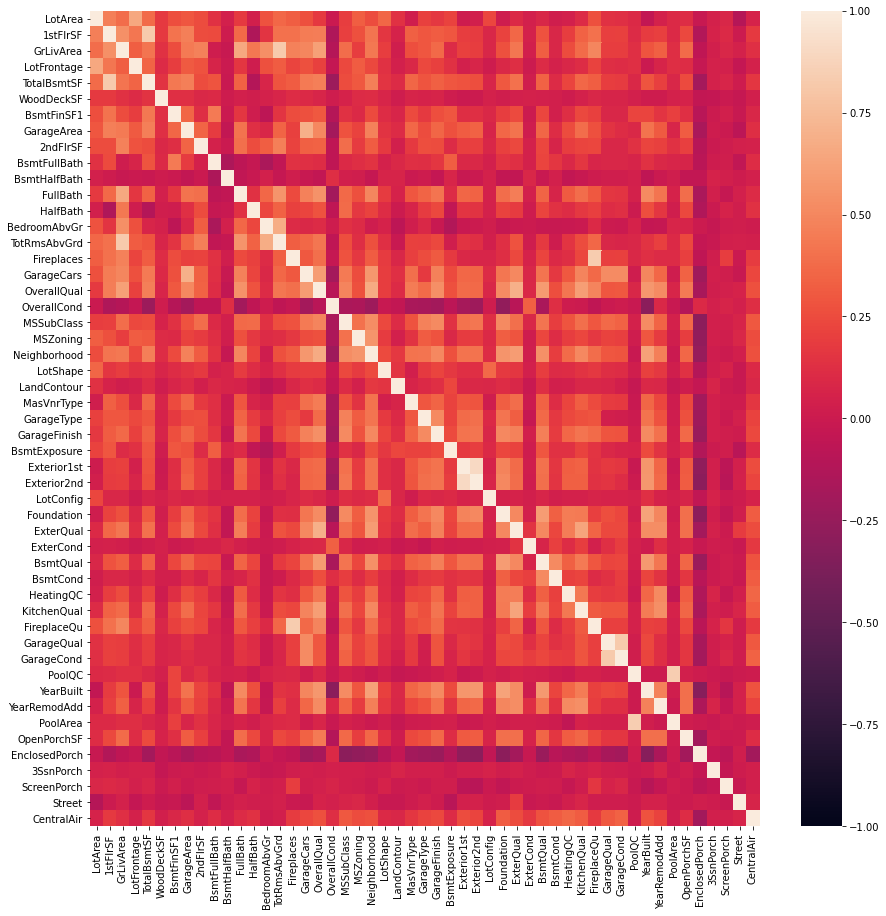

In [13]:
# plot the corr matrix between the numerical features
corr = df.corr()
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(corr, vmax=1, vmin=-1)
plt.show()

In [14]:
# include log price output variable
df["LogPrice"] = np.log(data["SalePrice"])
label_corr = df.corr()["LogPrice"]

In [15]:
# threshold for multicollinearity
threshold = 0.8

columns = corr.columns
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if abs(corr.iloc[i,j]) > threshold:
            
            index = np.argmin((abs(label_corr[i]), abs(label_corr[j])))
            
            print(f"Features: {columns[i]}[{label_corr[i].round(2)}] & {columns[j]}[{label_corr[j].round(2)}], feature corr. {round(corr.iloc[i, j], 2)}")
            print(70*"-")

# the brackets denote the overall label correlation

Features: 1stFlrSF[0.61] & TotalBsmtSF[0.59], feature corr. 0.83
----------------------------------------------------------------------
Features: GrLivArea[0.73] & TotRmsAbvGrd[0.53], feature corr. 0.83
----------------------------------------------------------------------
Features: Fireplaces[0.49] & FireplaceQu[0.54], feature corr. 0.83
----------------------------------------------------------------------
Features: Exterior1st[0.41] & Exterior2nd[0.39], feature corr. 0.9
----------------------------------------------------------------------
Features: GarageQual[0.37] & GarageCond[0.37], feature corr. 0.82
----------------------------------------------------------------------
Features: PoolQC[0.07] & PoolArea[0.07], feature corr. 0.84
----------------------------------------------------------------------


There is multicollinearity in this dataset (as already evident from checking out the correlation matrix). We'll keep those features with the largest output value correlation. Some reasons for multicollinearity are clear, e.g. PoolQC and PoolArea (if there is no Pool then there is also no Pool Quality to speak of). Interesting is also how the more fireplaces there are, the higher their quality (Fireplaces and FireplaceQu with lin. corr. coef. of 0.83.

We will keep those features with the highest linear output value correlation and remove those that are colinear. Features removed:

- TotalBsmtSF
- TotRmsAbvGrd
- Fireplaces
- Exterior2nd
- GarageCond
- PoolQC

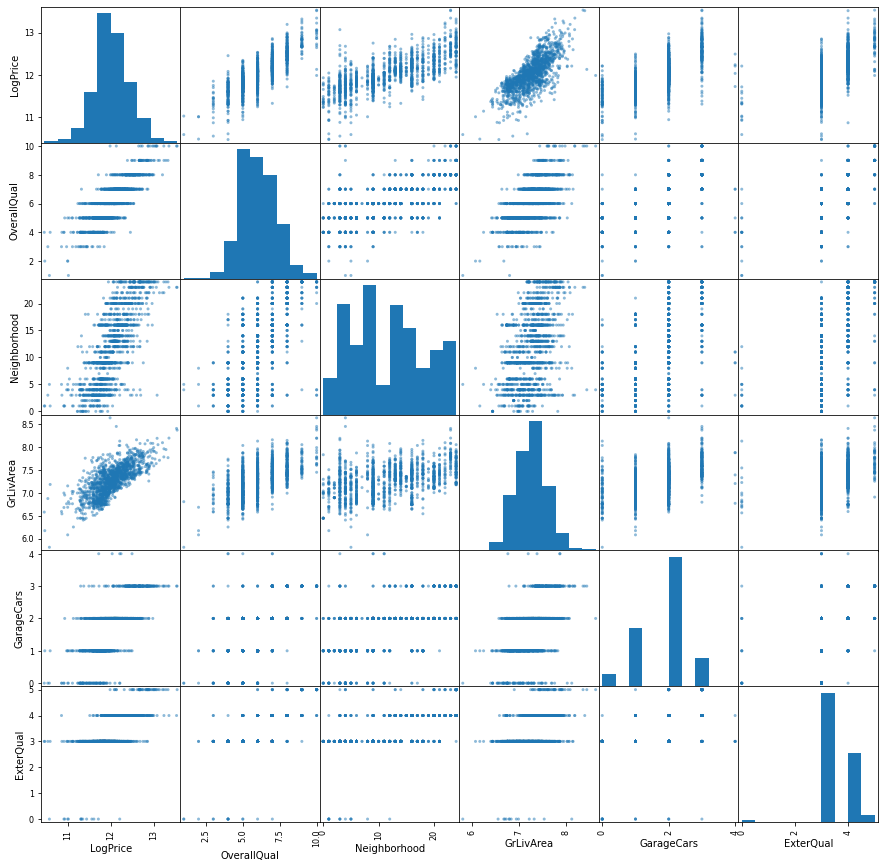

In [16]:
# visualize top 5 correlated features
top_5 = label_corr.sort_values(ascending=False)[0:6].index

data_vis = df[top_5]
pd.plotting.scatter_matrix(data_vis,
                          figsize=(15,15))
plt.show()

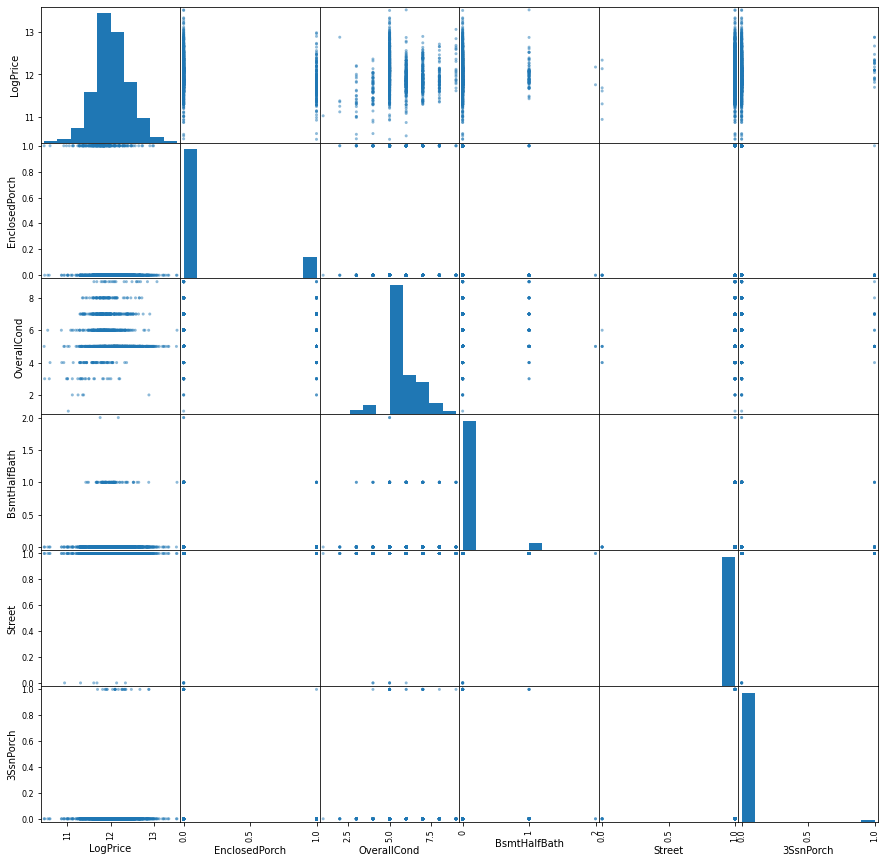

In [17]:
# visualize bottom 5 correlated features
bot_5 = ["LogPrice"] + label_corr.sort_values(ascending=True)[0:5].index.tolist()

data_vis = df[bot_5]
pd.plotting.scatter_matrix(data_vis,
                          figsize=(15,15))
plt.show()